In [1]:
import scipy
from scipy import spatial as sp

In [2]:
import plotly.figure_factory as ff

In [3]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
# StandardScaler is a function to normalize the data 
# You may also check MinMaxScaler and MaxAbsScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN


from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.mixture import GaussianMixture

import sklearn.metrics as met

%matplotlib inline
import plotly.figure_factory as ff

In [4]:
import matplotlib.cm as cm

In [25]:
from scipy.cluster.hierarchy import dendrogram

In [5]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmykrgykm'  #List colors
    alpha = 0.5  #color obaque
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [6]:
#helper function to display data after DBScan Clustering
def display_DBScan(labels,db,X,eps,min_samples):
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
        silScore=(met.silhouette_score(data, labels, metric = 'euclidean'))
        title="eps="+str(eps) + " n_samples=" + str(min_samples) + " Est.no.of clusters= "+ str(n_clusters_)+" SilScore= "+ str(silScore)
        plt.title(title)
    #plt.show()

In [7]:
#function to perform K-Means Clustering and save silhouette scores and distortions 
def KMeansClustering_euclidean(data,K):
    n = range(2,K+1)
    distortions=[]
    silScore=[]
    clustersArray=[]
    for i in n:
        km = KMeans(n_clusters=i)
        km=km.fit(data)
        distortions.append(sum(np.min(sp.distance.cdist(data,
            km.cluster_centers_, 'euclidean'),axis=1)) /
            data.shape[0])
        labels = km.labels_
        silScore.append(met.silhouette_score(data, labels, metric = 'euclidean'))
        clustersArray.append(km)
        plt.subplot(2,5, i-1)
        display_cluster(data,km,i)
        title='K='+str(i)
        plt.title(title)
    return distortions,silScore,clustersArray

In [8]:
def KMeansClustering_manhattan(data,K):
    n = range(2,K+1)
    distortions=[]
    silScore=[]
    clustersArray=[]
    for i in n:
        km = KMeans(n_clusters=i,init='random')
        km=km.fit(data)
        distortions.append(sum(np.min(sp.distance.cdist(data,
            km.cluster_centers_, 'euclidean'),axis=1)) /
            data.shape[0])
        labels = km.labels_
        silScore.append(met.silhouette_score(data, labels, metric = 'manhattan'))
        clustersArray.append(km)
        plt.subplot(2,5, i-1)
        display_cluster(data,km,i)
        title='K='+str(i)
        plt.title(title)
    return distortions,silScore,clustersArray

In [77]:
def aggloClustering(data,n_clusters):
    silhouette_avg=[]
    for i in range(2, n_clusters+1):
        agg = AgglomerativeClustering(n_clusters=i,compute_distances=True)
        agg_labels = agg.fit_predict(data)
       # plt.subplot(2,5, i-1)
        plt.figure(figsize=(10, 5))
        plot_dendrogram(agg)
       # dendrogram(agg.linkage_, leaf_font_size=8)
        title='n_clusters='+str(i) + 'Sil_Score=' +str(met.silhouette_score(data, agg_labels))
        plt.title(title)
        silhouette_avg.append(met.silhouette_score(data, agg_labels))
    return silhouette_avg

In [66]:
def plot_dendrogram(model, **kwargs):
        # Create linkage matrix and then plot the dendrogram
        # create the counts of samples under each node
        counts = np.zeros(model.children_.shape[0])
        n_samples = len(model.labels_)
        for i, merge in enumerate(model.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
                    counts[i] = current_count
                    
        linkage_matrix = np.column_stack([model.children_, model.distances_,
                                          counts]).astype(float)

        # Plot the corresponding dendrogram
        dendrogram(linkage_matrix, **kwargs)
        #plt.show()
          

In [10]:
def DBSCAN_Clustering2(data,eps,nsamples):
    silScores=[]
    db = DBSCAN(eps=eps, min_samples=nsamples)
    db.fit(data)
    labels = db.labels_
    silScores.append(met.silhouette_score(data, labels, metric = 'euclidean'))
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    display_DBScan(labels,db,data,eps,nsamples)
    return silScores

Importing the dataset:

In [11]:
df_customer = pd.read_csv("Customer data.csv",index_col=0)
customers_data = df_customer.select_dtypes(include=[np.number]).values

In [12]:
scaler = StandardScaler()
scaler.fit(df_customer)
scaled_data = scaler.transform(df_customer)
df_scaled = pd.DataFrame(scaled_data, columns=df_customer.columns)
customers_data_scaled = df_scaled.select_dtypes(include=[np.number]).values

Extracting features and normalising: 

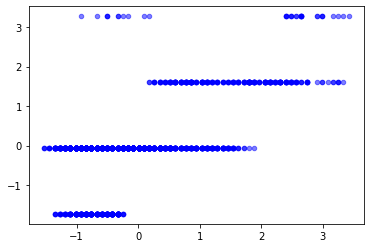

In [13]:
#Age vs Education 
df_customer_data_1=df_customer[["Age", "Education"]]
scaler = StandardScaler()
scaler.fit(df_customer_data_1)
scaled_data = scaler.transform(df_customer_data_1)
df_scaled = pd.DataFrame(scaled_data, columns=df_customer_data_1.columns)
customers_data_scaled_1 = df_scaled.select_dtypes(include=[np.number]).values
display_cluster(customers_data_scaled_1)

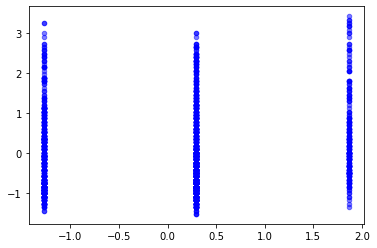

In [14]:
#Age vs Occupation
df_customer_data_2=df_customer[["Occupation", "Age"]]
scaler = StandardScaler()
scaler.fit(df_customer_data_2)
scaled_data = scaler.transform(df_customer_data_2)
df_scaled = pd.DataFrame(scaled_data, columns=df_customer_data_2.columns)
customers_data_scaled_2 = df_scaled.select_dtypes(include=[np.number]).values
display_cluster(customers_data_scaled_2)

In [15]:
K=6
n = range(2,K+1)

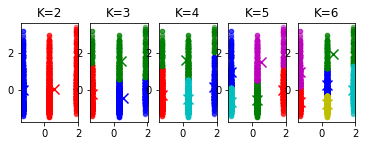

In [16]:
distFunc_2_euc,silScore_2_euc,clustersArray_2_euc=KMeansClustering_euclidean(customers_data_scaled_2,K)

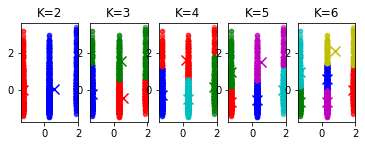

In [17]:
distFunc_2_man,silScore_2_man,clustersArray_2_man=KMeansClustering_manhattan(customers_data_scaled_2,K)

Text(0.5, 1.0, 'distFn: manhattan distance')

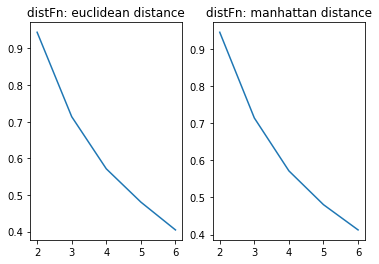

In [18]:
plt.subplot(1,2,1)
plt.plot(n,distFunc_2_euc)
plt.title("distFn: euclidean distance")
plt.subplot(1,2,2)
plt.plot(n,distFunc_2_man)
plt.title("distFn: manhattan distance")

Text(0.5, 1.0, 'silScore: manhattan distance')

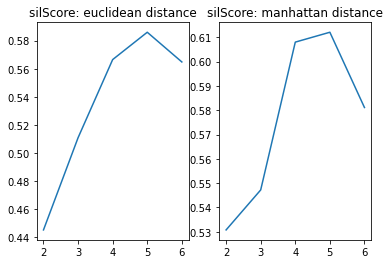

In [19]:
plt.subplot(1,2,1)
plt.plot(n,silScore_2_euc)
plt.title("silScore: euclidean distance")
plt.subplot(1,2,2)
plt.plot(n,silScore_2_man)
plt.title("silScore: manhattan distance")

In [79]:
silScore_2_euc.index(max(silScore_2_euc))+2

5

An attempt to initialise the cluster centroids to get better clustering still fails to cluster properly:

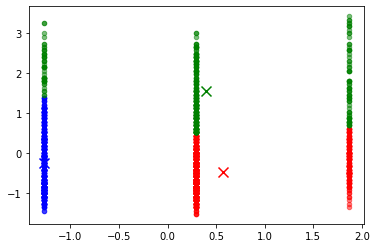

In [23]:
K=3
distortions=[]
silScore_2=[]
init_centroids = np.array([[-1, 1], [0, 1],[1,1]])
data=customers_data_scaled_2
km = KMeans(n_clusters=K,init=init_centroids)
km=km.fit(data)
distortions.append(sum(np.min(sp.distance.cdist(data,
    km.cluster_centers_, 'euclidean'),axis=1)) /
    data.shape[0])
labels = km.labels_
silScore_2.append(met.silhouette_score(data, labels, metric = 'euclidean'))
display_cluster(data,km,K)

In [55]:
silScore_db_2=[]

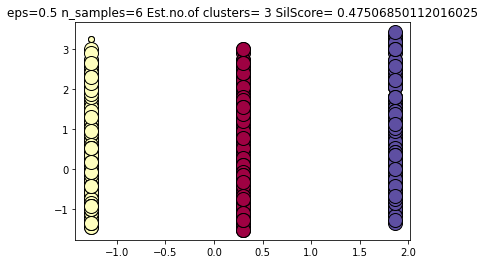

In [80]:
silScore_db_2.append(DBSCAN_Clustering2(customers_data_scaled_2,0.5,6))

In [ ]:
silScore_db_2

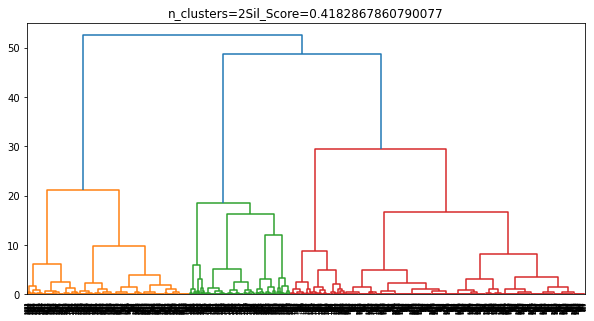

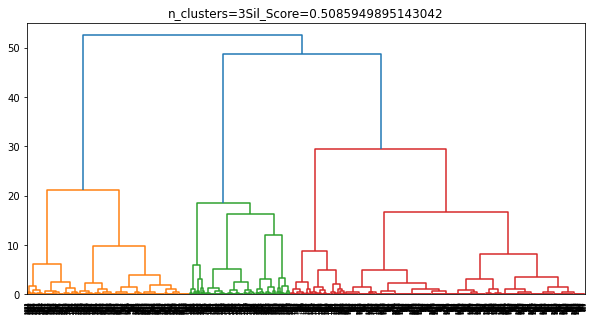

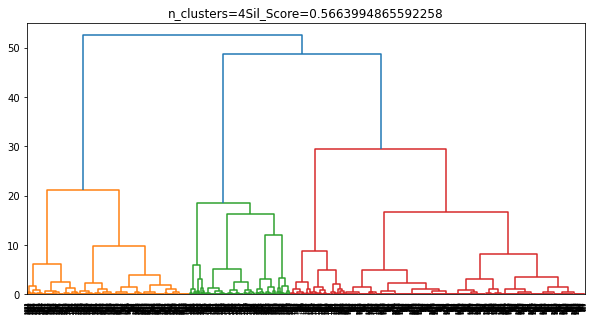

In [78]:
data=customers_data_scaled_2
n_clusters=4
silScore_agg=aggloClustering(data,n_clusters)

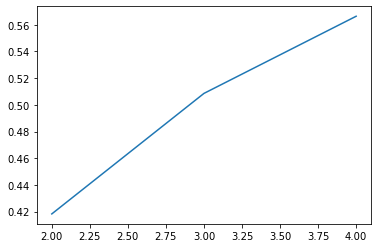

In [76]:
n = range(2,n_clusters+1)
silScore_agg
plt.plot(n,silScore_agg)

In [ ]:
#Age vs Marital status 
df_customer_data_3=df_customer[["Marital status", "Age"]]
scaler = StandardScaler()
scaler.fit(df_customer_data_3)
scaled_data = scaler.transform(df_customer_data_3)
df_scaled = pd.DataFrame(scaled_data, columns=df_customer_data_3.columns)
customers_data_scaled_3 = df_scaled.select_dtypes(include=[np.number]).values
display_cluster(customers_data_scaled_3)

In [ ]:
#Age vs Settlement size 
df_customer_data_4=df_customer[["Settlement size", "Age"]]
scaler = StandardScaler()
scaler.fit(df_customer_data_4)
scaled_data = scaler.transform(df_customer_data_4)
df_scaled = pd.DataFrame(scaled_data, columns=df_customer_data_4.columns)
customers_data_scaled_4 = df_scaled.select_dtypes(include=[np.number]).values
display_cluster(customers_data_scaled_4)

In [ ]:
#Age vs Income
df_customer_data_5=df_customer[["Age", "Income"]]
scaler = StandardScaler()
scaler.fit(df_customer_data_5)
scaled_data = scaler.transform(df_customer_data_5)
df_scaled = pd.DataFrame(scaled_data, columns=df_customer_data_5.columns)
customers_data_scaled_5 = df_scaled.select_dtypes(include=[np.number]).values
display_cluster(customers_data_scaled_5)

In [ ]:
K=11
n = range(2,K+1)

In [ ]:
distFunc_5_euc,silScore_5_euc,clustersArray_5_euc=KMeansClustering_euclidean(customers_data_scaled_5,K)

In [ ]:
distFunc_5_man,silScore_5_man,clustersArray_5_man=KMeansClustering_manhattan(customers_data_scaled_5,K)

In [ ]:
plt.subplot(1,2,1)
plt.plot(n,silScore_5_euc)
plt.title("silScore: euclidean distance")
plt.subplot(1,2,2)
plt.plot(n,silScore_5_man)
plt.title("silScore: manhattan distance")

In [ ]:
plt.subplot(1,2,1)
plt.plot(n,distFunc_5_euc)
plt.title("distFn: euclidean distance")
plt.subplot(1,2,2)
plt.plot(n,distFunc_5_man)
plt.title("distFn: manhattan distance")

In [ ]:
silScore_db_5=(DBSCAN_Clustering2(customers_data_scaled_5,1.5,25))

In [ ]:
silScore_db_5=(DBSCAN_Clustering2(customers_data_scaled_5,1,20))